In [1]:
import os
import os.path
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch 
import random
from torch import nn
from torch.distributions.normal import Normal
from functools import partial
from tqdm import trange, tqdm_notebook
from urllib.request import urlretrieve
import gzip
import struct
import array

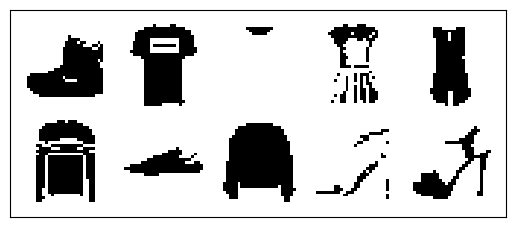

In [2]:
def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')
    
    # Remove the data point that cause log(0)
    remove = (14926, 20348, 36487, 45128, 50945, 51163, 55023)
    train_images = np.delete(train_images,remove, axis=0)
    train_labels = np.delete(train_labels, remove, axis=0)
    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_fashion_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels =  fashion_mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_images, test_images = np.float32(train_images), np.float32(test_images)
    train_labels = torch.tensor(one_hot(train_labels, 10))
    test_labels = torch.tensor(one_hot(test_labels, 10))
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

N_data, train_images, train_labels, test_images, test_labels = load_fashion_mnist()

def plot_images(images, ims_per_row=5, padding=5, dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((dimensions[0] + padding) * N_rows + padding,
                             (dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + dimensions[0]) * row_ix
        col_start = padding + (padding + dimensions[1]) * col_ix
        concat_images[row_start: row_start + dimensions[0],
                      col_start: col_start + dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    plt.plot()

plot_images(train_images[:10, :])

In [6]:
from torch.utils.data import TensorDataset, DataLoader
from vae import diag_gaussian_log_density, diag_gaussian_samples, diag_gaussian_logpdf, log_prior, batch_elbo
# Define a specific VAE for MNIST

data_dimension = 28*28
latent_dimension = 20

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension) 
# Define the decoder network.
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU(),
            nn.Linear(50, data_dimension)
        )
    def forward(self, x):
        return self.net(x)

decoder_net = Decoder(latent_dimension, data_dimension) 

# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
    """Bernoulli log pdf of data x given logits."""
    return -torch.sum(torch.logaddexp(torch.tensor([0.]), torch.where(x > 0.5, -1., 1.) * logits), dim=1)

def log_likelihood(decoder_net, latent, data): 
    mean = decoder_net(latent)
    return bernoulli_logpdf(mean, data)

def log_joint(decoder_net, latent, data): 
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-2)
n_iters = 5000
minibatch_size = 200

dataset = TensorDataset(torch.tensor(train_images), )
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.  
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

callback(n_iters)

Optimizing variational parameters...


  0%|          | 13/5000 [00:00<00:39, 127.75it/s]

Iteration 0 lower bound -677.1807250976562


  3%|▎         | 126/5000 [00:00<00:35, 137.60it/s]

Iteration 100 lower bound -335.6181640625


  5%|▍         | 229/5000 [00:01<00:34, 138.86it/s]

Iteration 200 lower bound -315.5287780761719


  6%|▋         | 316/5000 [00:02<00:33, 138.31it/s]

Iteration 300 lower bound -256.6965637207031


  9%|▊         | 433/5000 [00:02<00:24, 184.97it/s]

Iteration 400 lower bound -250.70858764648438


 11%|█         | 532/5000 [00:03<00:23, 190.87it/s]

Iteration 500 lower bound -211.33131408691406


 13%|█▎        | 632/5000 [00:03<00:22, 191.78it/s]

Iteration 600 lower bound -236.55601501464844


 15%|█▍        | 731/5000 [00:04<00:23, 185.36it/s]

Iteration 700 lower bound -243.41334533691406


 16%|█▋        | 823/5000 [00:05<00:24, 169.98it/s]

Iteration 800 lower bound -223.17779541015625


 19%|█▊        | 927/5000 [00:05<00:24, 166.73it/s]

Iteration 900 lower bound -220.7924346923828


 21%|██        | 1033/5000 [00:06<00:23, 170.97it/s]

Iteration 1000 lower bound -195.5063934326172


 22%|██▏       | 1121/5000 [00:06<00:23, 168.49it/s]

Iteration 1100 lower bound -205.97879028320312


 25%|██▍       | 1229/5000 [00:07<00:21, 171.76it/s]

Iteration 1200 lower bound -202.64047241210938


 26%|██▋       | 1319/5000 [00:07<00:21, 172.47it/s]

Iteration 1300 lower bound -209.2941436767578


 29%|██▊       | 1427/5000 [00:08<00:20, 171.64it/s]

Iteration 1400 lower bound -187.87664794921875


 31%|███       | 1535/5000 [00:09<00:20, 171.49it/s]

Iteration 1500 lower bound -186.1421356201172


 32%|███▎      | 1625/5000 [00:09<00:19, 171.07it/s]

Iteration 1600 lower bound -177.45916748046875


 35%|███▍      | 1733/5000 [00:10<00:19, 171.03it/s]

Iteration 1700 lower bound -184.08775329589844


 36%|███▋      | 1823/5000 [00:10<00:18, 170.89it/s]

Iteration 1800 lower bound -182.44459533691406


 39%|███▊      | 1931/5000 [00:11<00:17, 170.97it/s]

Iteration 1900 lower bound -178.04019165039062


 40%|████      | 2021/5000 [00:12<00:17, 171.02it/s]

Iteration 2000 lower bound -178.5480499267578


 43%|████▎     | 2129/5000 [00:12<00:16, 171.10it/s]

Iteration 2100 lower bound -196.9189453125


 44%|████▍     | 2219/5000 [00:13<00:16, 170.84it/s]

Iteration 2200 lower bound -182.3472442626953


 47%|████▋     | 2327/5000 [00:13<00:15, 171.06it/s]

Iteration 2300 lower bound -186.20816040039062


 49%|████▊     | 2435/5000 [00:14<00:15, 170.14it/s]

Iteration 2400 lower bound -175.3004913330078


 50%|█████     | 2525/5000 [00:14<00:14, 170.86it/s]

Iteration 2500 lower bound -163.2860107421875


 53%|█████▎    | 2633/5000 [00:15<00:13, 169.78it/s]

Iteration 2600 lower bound -194.41253662109375


 54%|█████▍    | 2723/5000 [00:16<00:13, 170.15it/s]

Iteration 2700 lower bound -176.98048400878906


 57%|█████▋    | 2831/5000 [00:16<00:12, 170.02it/s]

Iteration 2800 lower bound -163.8749542236328


 58%|█████▊    | 2921/5000 [00:17<00:12, 169.15it/s]

Iteration 2900 lower bound -178.9228973388672


 60%|██████    | 3021/5000 [00:18<00:13, 142.80it/s]

Iteration 3000 lower bound -177.0766143798828


 62%|██████▏   | 3116/5000 [00:18<00:14, 133.21it/s]

Iteration 3100 lower bound -168.46568298339844


 65%|██████▍   | 3230/5000 [00:19<00:12, 146.96it/s]

Iteration 3200 lower bound -190.1876220703125


 66%|██████▌   | 3312/5000 [00:20<00:11, 149.45it/s]

Iteration 3300 lower bound -197.91490173339844


 68%|██████▊   | 3421/5000 [00:20<00:11, 133.69it/s]

Iteration 3400 lower bound -178.6107177734375


 70%|███████   | 3520/5000 [00:21<00:10, 137.96it/s]

Iteration 3500 lower bound -169.05535888671875


 73%|███████▎  | 3631/5000 [00:22<00:09, 149.15it/s]

Iteration 3600 lower bound -179.8412322998047


 74%|███████▍  | 3725/5000 [00:23<00:09, 136.27it/s]

Iteration 3700 lower bound -166.71290588378906


 76%|███████▋  | 3820/5000 [00:23<00:09, 129.59it/s]

Iteration 3800 lower bound -180.4568328857422


 79%|███████▊  | 3932/5000 [00:24<00:07, 149.78it/s]

Iteration 3900 lower bound -169.05633544921875


 81%|████████  | 4027/5000 [00:25<00:06, 145.55it/s]

Iteration 4000 lower bound -180.58355712890625


 82%|████████▏ | 4122/5000 [00:25<00:06, 139.47it/s]

Iteration 4100 lower bound -176.66287231445312


 84%|████████▍ | 4215/5000 [00:26<00:05, 131.72it/s]

Iteration 4200 lower bound -186.2332000732422


 87%|████████▋ | 4329/5000 [00:27<00:04, 144.74it/s]

Iteration 4300 lower bound -175.8062744140625


 88%|████████▊ | 4424/5000 [00:27<00:03, 151.73it/s]

Iteration 4400 lower bound -164.21987915039062


 90%|█████████ | 4518/5000 [00:28<00:03, 136.84it/s]

Iteration 4500 lower bound -167.34397888183594


 92%|█████████▏| 4614/5000 [00:29<00:02, 130.29it/s]

Iteration 4600 lower bound -166.06805419921875


 95%|█████████▍| 4727/5000 [00:30<00:01, 149.57it/s]

Iteration 4700 lower bound -169.3477020263672


 96%|█████████▋| 4821/5000 [00:30<00:01, 146.02it/s]

Iteration 4800 lower bound -170.58480834960938


 98%|█████████▊| 4917/5000 [00:31<00:00, 139.35it/s]

Iteration 4900 lower bound -168.1946258544922


100%|██████████| 5000/5000 [00:32<00:00, 155.83it/s]

Iteration 5000 lower bound -198.8996124267578


torch.Size([25, 20])


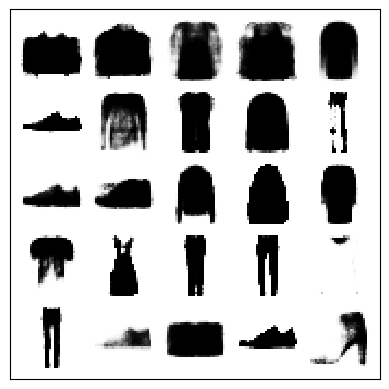

In [8]:
# Sample data from the trained generative model to see if it
# roughly matches the data.

def sigmoid(x):
  # Maps logits to probabilities.
  return 0.5 * (torch.tanh(x) + 1.0)

sampled_zs = diag_gaussian_samples(torch.zeros(latent_dimension), torch.ones(latent_dimension), 25)
print(sampled_zs.size())
bernoulli_means = sigmoid(decoder_net(sampled_zs).detach())
plot_images(bernoulli_means)

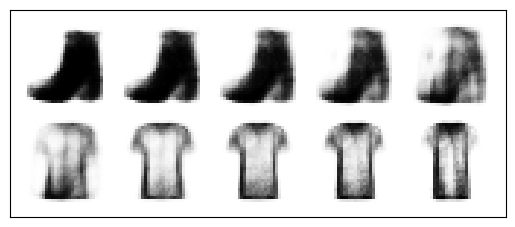

In [10]:
# interpolation between latent spaces of two images
def plot_interp(ix1, ix2):
    left_z = recognition_net(torch.tensor(train_images[ix1, :]).to(torch.float32))[0].detach()
    right_z = recognition_net(torch.tensor(train_images[ix2, :]).to(torch.float32))[0].detach()
    interp_zs = right_z + torch.linspace(0.0, 1.0, 10)[:, None] * (left_z - right_z)
    bernoulli_means = sigmoid(decoder_net(interp_zs).detach())
    plot_images(bernoulli_means)

plot_interp(3, 11)